In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
print (os.environ['CONDA_DEFAULT_ENV'])

self_supervised_eman


In [3]:
import tensorflow as tf
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16922981760488328081
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 18076219051759510949
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10502284288
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13229441683305695472
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5906611176191026151
physical_device_desc: "device: XLA_GPU device"
]


# autoencoder

In [5]:
import keras
from keras.layers import BatchNormalization, Activation, Input
from keras.layers import Reshape, UpSampling2D, Conv2D
from keras.models import Model
from keras.datasets import cifar10
from keras.optimizers import Adam

import cv2
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [6]:

#from keras.initializers import he_normal

def build_encoder(x):
    input_ = Input(x.shape[1:])

    c = Conv2D(32, (3, 3), padding="same", strides=2)(input_)
    c = BatchNormalization()(c)
    c = Activation("relu")(c)
    c = Conv2D(64, (3, 3), padding="same", strides=2)(c)
    c = BatchNormalization()(c)
    c = Activation("relu")(c)
    c = Conv2D(128, (3, 3), padding="same", strides=2)(c)
    c = BatchNormalization()(c)
    c = Activation("relu")(c)
    c = Conv2D(256, (3, 3), padding="same", strides=2)(c)
    c = BatchNormalization()(c)
    c = Activation("relu")(c)
    c = Conv2D(512, (3, 3), padding="same", strides=2)(c)
    c = BatchNormalization()(c)
    c = Activation("relu")(c)

    return Model(inputs=input_, outputs=c)

def build_decoder(x):
    #input_ = Input([1, 1, 512])
    input_ = Input([int(x.shape[1]/16), int(x.shape[2]/16), 512])
    c = Conv2D(512, (3, 3), padding="same")(input_)
    c = BatchNormalization()(c)
    c = Activation("relu")(c)
    c = UpSampling2D((2,2))(c)#4*4
    c = Conv2D(256, (3, 3), padding="same")(c)
    c = BatchNormalization()(c)
    c = Activation("relu")(c)
    c = UpSampling2D((2,2))(c)#8*8
    c = Conv2D(128, (3, 3), padding="same")(c)
    c = BatchNormalization()(c)
    c = Activation("relu")(c)
    c = UpSampling2D((2,2))(c)#16*16
    c = Conv2D(64, (3, 3), padding="same")(c)
    c = BatchNormalization()(c)
    c = Activation("relu")(c)
    c = UpSampling2D((2,2))(c)#32*32
    c = Conv2D(32, (3, 3), padding="same")(c)
    c = BatchNormalization()(c)
    c = Activation("relu")(c)
    c = UpSampling2D((2,2))(c)#32*32

    c = Conv2D(3, (1, 1), padding="same")(c)
    c = BatchNormalization()(c)
    c = Activation("sigmoid")(c)

    return Model(inputs=input_, outputs=c)

def cifar():
    # dataset
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255

    return x_train, x_test, y_train, y_test

def train_autoencoder(x, epoch):
    encoder = build_encoder(x)
    decoder = build_decoder(x)
    input_ = Input(x.shape[1:])
    ae = Model(inputs = input_, outputs = decoder(encoder(input_)))

    ae.compile(loss='mse',
              optimizer=Adam())

    hist = ae.fit(x,
                  x,
                  batch_size=128,
                  epochs=epoch,
                  verbose = False)
    
    return ae, encoder




In [ ]:
def read_image(p):
    path = '/home/admin1/Documents/EmanEhab/CSG/ROI/' + p
    img = cv2.imread(path, 1)
    img = cv2.resize(img, (32, 32), interpolation = cv2.INTER_AREA)
    img = img.astype('float32') / 255
    return img
def traffic_dataset(path):
    df = pd.read_csv(path, names=['image_path', 'label'])
    
    X = np.stack(df["image_path"].apply(read_image).to_numpy())
    
    y= np.array(df['label']).reshape(len(df['label']),1).astype("int8")
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=42)
    #Saving into pickles
    dict = {'x_train': x_train, 'x_test': x_test, 'y_train': y_train, "y_test":y_test}
    file = open('Normalized_traffic_dataset_train_test_pickles.txt', 'wb')
    pickle.dump(dict, file)
    file.close()
    
    
    return X_train, X_test, y_train, y_test



x_train, x_test, y_train, y_test = traffic_dataset("./data_1.csv")

### Reading from Saved pickles

In [5]:
file = open('Normalized_traffic_dataset_train_test_pickles.txt', 'rb')
dict = pickle.load(file)
#x_train, x_test, y_train, y_test
x_train, x_test, y_train, y_test = dict['x_train'], dict['x_test'], dict['y_train'], dict['y_test']
del(dict)

In [6]:
x_train.shape

(16028, 32, 32, 3)

def read_image(p):
    path = '/home/admin1/Documents/EmanEhab/CSG/ROI/' + p
    img = cv2.imread(path, 1)
    
    return img
def traffic_dataset(path):
    df = pd.read_csv(path, names=['image_path', 'label'])
    
    X = np.stack(df["image_path"].apply(read_image).to_numpy())
    
    y= np.array(df['label']).reshape(len(df['label']),1).astype("int8")
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=42)
    
    X_train = X_train.astype('float32') / 255
    X_test = X_test.astype('float32') / 255
    
    return X_train, X_test, y_train, y_test

def read_traffic_dataset(pickles_path):
    file = open(pickles_path, 'rb')
    dict = pickle.load(file)
    X_train, X_test, y_train, y_test = train_test_split(dict["X"], dict["y"], test_size=0.25)
    #X_train = X_train.astype('float32') / 255
    #X_test = X_test.astype('float32') / 255
    
    return X_train, X_test, y_train, y_test

#x_train, x_test, y_train, y_test = traffic_dataset("../roi_annotation.txt")

x_train, x_test, y_train, y_test = read_traffic_dataset("./traffic_dataset_pickles.txt")

#model, encoder = train_autoencoder(x_train)

## Equal classes

In [7]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 10645, 1: 1592, 2: 1374, 3: 638, 4: 592, 5: 543, 6: 377, 7: 142, 8: 125}

In [8]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 3466, 1: 561, 2: 466, 3: 232, 4: 201, 5: 177, 6: 154, 7: 49, 8: 37}

In [9]:
new_x_train = np.array([])
new_y_train = np.array([])

c0, c1, c2, c3, c4, c5, c6, c7, c8 = 0, 0, 0, 0, 0, 0, 0, 0, 0
contentes = list(range(0, 9))

for i in range(len(y_train)):
    
    if (y_train[i] == 0 ) and (c0 < 125):

        new_x_train = np.append(new_x_train, x_train[i])
        new_y_train = np.append(new_y_train, y_train[i])
        c0+=1
        
    elif (y_train[i] == 1 ) and (c1 < 125):
        new_x_train = np.append(new_x_train, x_train[i])
        new_y_train = np.append(new_y_train, y_train[i])
        c1+=1
        
    elif (y_train[i] == 2 ) and (c2 < 125):
        new_x_train = np.append(new_x_train, x_train[i])
        new_y_train = np.append(new_y_train, y_train[i])
        c2+=1
        
    elif (y_train[i] == 3 ) and (c3 < 125):
        new_x_train = np.append(new_x_train, x_train[i])
        new_y_train = np.append(new_y_train, y_train[i])
        c3+=1
        
    elif (y_train[i] == 4 ) and (c4 < 125):
        new_x_train = np.append(new_x_train, x_train[i])
        new_y_train = np.append(new_y_train, y_train[i])
        c4+=1
        
    elif (y_train[i] == 5 ) and (c5 < 125):
        new_x_train = np.append(new_x_train, x_train[i])
        new_y_train = np.append(new_y_train, y_train[i])
        c5+=1
        
    elif (y_train[i] == 6 ) and (c6 < 125):
        new_x_train = np.append(new_x_train, x_train[i])
        new_y_train = np.append(new_y_train, y_train[i])
        c6+=1
        
    elif (y_train[i] == 7 ) and (c7 < 125):
        new_x_train = np.append(new_x_train, x_train[i])
        new_y_train = np.append(new_y_train, y_train[i])
        c7+=1
        
    elif (y_train[i] == 8 ) and (c8 < 125):
        new_x_train = np.append(new_x_train, x_train[i])
        new_y_train = np.append(new_y_train, y_train[i])
        c8+=1
    else:
        pass

        
new_x_train = new_x_train.reshape((len(new_y_train), 32, 32, 3))
new_y_train = new_y_train.reshape((len(new_y_train), 1))

print(new_x_train.shape)
print(new_y_train.shape)

(1125, 32, 32, 3)
(1125, 1)


In [10]:
unique, counts = np.unique(new_y_train, return_counts=True)
dict(zip(unique, counts))

{0.0: 125,
 1.0: 125,
 2.0: 125,
 3.0: 125,
 4.0: 125,
 5.0: 125,
 6.0: 125,
 7.0: 125,
 8.0: 125}

In [11]:
new_x_test = np.array([])
new_y_test = np.array([])

c0, c1, c2, c3, c4, c5, c6, c7, c8 = 0, 0, 0, 0, 0, 0, 0, 0, 0
contentes = list(range(0, 9))

for i in range(len(y_test)):
    
    if (y_test[i] == 0 ) and (c0 < 37):

        new_x_test = np.append(new_x_test, x_test[i])
        new_y_test = np.append(new_y_test, y_test[i])
        c0+=1
        
    elif (y_test[i] == 1 ) and (c1 < 37):
        new_x_test = np.append(new_x_test, x_test[i])
        new_y_test = np.append(new_y_test, y_test[i])
        c1+=1
        
    elif (y_test[i] == 2 ) and (c2 < 37):
        new_x_test = np.append(new_x_test, x_test[i])
        new_y_test = np.append(new_y_test, y_test[i])
        c2+=1
        
    elif (y_test[i] == 3 ) and (c3 < 37):
        new_x_test = np.append(new_x_test, x_test[i])
        new_y_test = np.append(new_y_test, y_test[i])
        c3+=1
        
    elif (y_test[i] == 4 ) and (c4 < 37):
        new_x_test = np.append(new_x_test, x_test[i])
        new_y_test = np.append(new_y_test, y_test[i])
        c4+=1
        
    elif (y_test[i] == 5 ) and (c5 < 37):
        new_x_test = np.append(new_x_test, x_test[i])
        new_y_test = np.append(new_y_test, y_test[i])
        c5+=1
        
    elif (y_test[i] == 6 ) and (c6 < 37):
        new_x_test = np.append(new_x_test, x_test[i])
        new_y_test = np.append(new_y_test, y_test[i])
        c6+=1
        
    elif (y_test[i] == 7 ) and (c7 < 37):
        new_x_test = np.append(new_x_test, x_test[i])
        new_y_test = np.append(new_y_test, y_test[i])
        c7+=1
        
    elif (y_test[i] == 8 ) and (c8 < 37):
        new_x_test = np.append(new_x_test, x_test[i])
        new_y_test = np.append(new_y_test, y_test[i])
        c8+=1
    else:
        pass

        
new_x_test = new_x_test.reshape((len(new_y_test), 32, 32, 3))
new_y_test = new_y_test.reshape((len(new_y_test), 1))
print(new_x_test.shape)
print(new_y_test.shape)

(333, 32, 32, 3)
(333, 1)


In [12]:
x_train = new_x_train
y_train = new_y_train
x_test = new_x_test
y_test = new_y_test

In [13]:
y_test.shape

(333, 1)

# CSG

# MDS

In [14]:
from sklearn import manifold
from matplotlib.collections import LineCollection

#cifar10のラベル
mds_label = ['Car', 'Pedstrian', 'NoStop', 'CurveLeft', 'Walk', 'Bump', 'Uturn', 'Split', 'Merge']

"""mds_label = ['airplane',
             'automobile',
             'bird',
             'cat',
             'deer',
             'dog',
             'frog',
             'horse',
             'ship',
             'truck']"""

def MDS(W):
    #mds
    mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9,
                       dissimilarity="precomputed", n_jobs=1)
    pos = mds.fit(1-W).embedding_

    plt.figure(figsize=(5,5))
    ax = plt.axes([0., 0., 1., 1.])

    for (xx, yy), l in zip(pos, mds_label):
        plt.text(xx, yy, l, fontsize=20)

    segments = [[pos[i, :], pos[j, :]]
                for i in range(len(pos)) for j in range(len(pos))]
    lc = LineCollection(segments,
                        zorder=0, cmap=plt.cm.Blues,
                        norm=plt.Normalize(0, 0.5))
    lc.set_linewidths(np.full(len(segments), 0.5))
    ax.add_collection(lc)
    plt.scatter(pos[:, 0], pos[:, 1], color='turquoise', lw=0, label='MDS')
    plt.axis("off")
    plt.show()

# evaluate

In [16]:
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from keras.utils.np_utils import to_categorical
import seaborn as sns

def t_sne(x, label, encoder, fig=True):
    embed = encoder.predict(x)
    test_s = embed.reshape((len(embed),-1))

    X_reduced = TSNE(n_components=2).fit_transform(test_s)

    if fig == True:
        plt.figure(figsize=(12,9))
        plt.scatter(X_reduced[:, 0], X_reduced[:, 1],c=label.reshape(-1), cmap="jet")
        plt.colorbar()
        plt.show()

    return X_reduced
    
def random_choise(x, label, M=10, k=9):
    result_x, result_y = [], []

    for i in range(k):
        result = []
        for j in range(len(label)):
            if label[j] == i:
                result.append(j)
        
        number = np.random.choice(np.arange(0, len(result)), M, replace=False)
        for o in number:
                result_x.append(x[result[o]])
                result_y.append(i)
    return np.array(result_x), np.array(result_y)
                                        
def p_cj(xi, xj, M=10, V=1):
    neigh = KNeighborsClassifier(n_neighbors=3)
    X = np.vstack((xi,xj))
    y = np.zeros(len(xi)+len(xj))
    y[len(xi):] = 1
    neigh.fit(X, y) 
    return M*np.mean(neigh.predict_proba(xj)[:,0])/(M*V)

def make_S(embed, label, k=9):
    S=np.eye(k)

    for i in range(k):
        for j in range(k):
            if i == j:
                pass
            else:
                class_i, class_j = [], []
                for o in range(len(label)):
                    if label[o] == i:
                        class_i.append(embed[o])
                    elif label[o] == j:
                        class_j.append(embed[o])
                S[i,j] = p_cj(class_i, class_j)

    return S

def w_ij(S, k=9):
    W = np.eye(k)
    #上三角だけ計算
    for i in range(k-1):
        for j in range(i, k):
            W[i,j] = 1 - np.sum(np.abs(S[i,:]-S[j,:])) / np.sum(np.abs(S[i,:]+S[j,:]))

    #下三角はコピー
    for i in range(1,k):
        for j in range(0,i+1):
            W[i,j] = np.copy(W[j,i])

    return W

def csg(W, k=9):
    # D
    sum_W = np.sum(W, axis=0)
    D = np.zeros((k,k))
    for i in range(k):
        D[i,i] = sum_W[i]

    # csg
    L = D-W
    eig = np.linalg.eig(L)[0]
    eig = np.sort(eig)

    eig_norm=[]
    for i in range(k-1):
        eig_norm.append((eig[i+1]-eig[i])/(k-i))

    # cummax
    result_csg = []
    for i in range(len(eig_norm)):
        result_csg.append(np.max(eig_norm[:i+1]))

    return np.sum(result_csg)

Start Evaluating: 
size is 5
data size= 5 : csg= 5.202206902127619
Size: 5 finished ----------------------------------------------------
size is 10
data size= 10 : csg= 5.130749882727036
Size: 10 finished ----------------------------------------------------
size is 15
data size= 15 : csg= 4.7458759861461735
Size: 15 finished ----------------------------------------------------
size is 20
data size= 20 : csg= 5.072942696048713
Size: 20 finished ----------------------------------------------------
size is 25
data size= 25 : csg= 5.0078804761614
Size: 25 finished ----------------------------------------------------
size is 30
data size= 30 : csg= 5.24623437167821
Size: 30 finished ----------------------------------------------------
size is 35
data size= 35 : csg= 4.945326900033674
Size: 35 finished ----------------------------------------------------
size is 40
data size= 40 : csg= 5.278644339135228
Size: 40 finished ----------------------------------------------------
size is 45
data si

data size= 55 : csg= 5.138059351036967
Size: 55 finished ----------------------------------------------------
size is 60
data size= 60 : csg= 5.002952791190474
Size: 60 finished ----------------------------------------------------
size is 65
data size= 65 : csg= 4.644629851677539
Size: 65 finished ----------------------------------------------------
size is 70
data size= 70 : csg= 4.683177846509548
Size: 70 finished ----------------------------------------------------
size is 75
data size= 75 : csg= 5.093507356573005
Size: 75 finished ----------------------------------------------------
size is 80
data size= 80 : csg= 4.783737969248885
Size: 80 finished ----------------------------------------------------
size is 85
data size= 85 : csg= 4.969477614651218
Size: 85 finished ----------------------------------------------------
size is 90
data size= 90 : csg= 4.968026843217794
Size: 90 finished ----------------------------------------------------
size is 95
data size= 95 : csg= 4.813329895

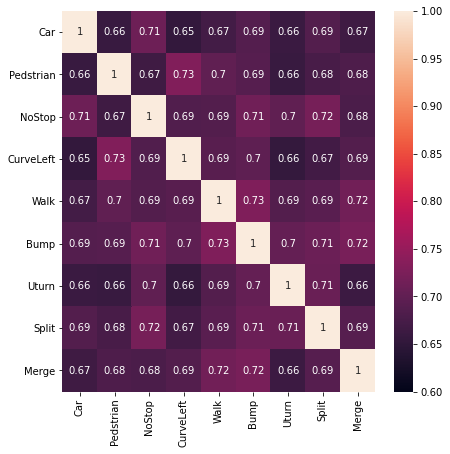

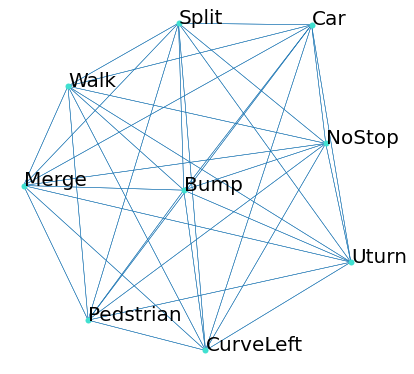

Size: 125 finished ----------------------------------------------------
--- 173.42847967147827 seconds ---


In [18]:
print("Start Evaluating: ")
start_time = time.time()
for size in range(5, 130, 5):
    print(f"size is {size}")
    result_W = np.zeros((9,9))
    
    x_train_small, y_train_small = random_choise(x_train, y_train, M=size)
    CSG = []
    model, encoder = train_autoencoder(x_train_small, int(125*50/(size*100)))
    for k in range(5):
        X_test, Y_test = random_choise(x_test, y_test)
        #print(np.sum(to_categorical(Y_test), axis=0))

        for i in range(5):
            X_tsne = t_sne(X_test, Y_test, encoder, fig=False)
            S = make_S(X_tsne, Y_test)
            W = w_ij(S)
            CSG.append(csg(W))
            result_W += W
    print("data size=", size, ": csg=",np.mean(CSG))

    # MDS
    if size == 125:
        result_W /= 25
        plt.figure(figsize=(7,7))
        sns.heatmap(result_W, annot=True, xticklabels=mds_label, yticklabels=mds_label, vmin=0.6, vmax=1)
        plt.show()

        MDS(result_W)
    print(f"Size: {size} finished ----------------------------------------------------")
end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))

Start Evaluating: 
size is 5
data size= 5 : csg= 4.684731189892924
Size: 5 finished ----------------------------------------------------
size is 10
data size= 10 : csg= 4.4375304069976
Size: 10 finished ----------------------------------------------------
size is 15
data size= 15 : csg= 5.075624422507941
Size: 15 finished ----------------------------------------------------
size is 20
data size= 20 : csg= 4.834416166952888
Size: 20 finished ----------------------------------------------------
size is 25
data size= 25 : csg= 5.12760755053014
Size: 25 finished ----------------------------------------------------
size is 30
data size= 30 : csg= 4.846340208093006
Size: 30 finished ----------------------------------------------------
size is 35
data size= 35 : csg= 5.092540149491298
Size: 35 finished ----------------------------------------------------
size is 40
data size= 40 : csg= 4.885204694453297
Size: 40 finished ----------------------------------------------------
size is 45
data siz

data size= 55 : csg= 4.665291610309624
Size: 55 finished ----------------------------------------------------
size is 60
data size= 60 : csg= 4.946620173116517
Size: 60 finished ----------------------------------------------------
size is 65
data size= 65 : csg= 4.946896280411976
Size: 65 finished ----------------------------------------------------
size is 70
data size= 70 : csg= 4.904887886336781
Size: 70 finished ----------------------------------------------------
size is 75
data size= 75 : csg= 5.008353328822586
Size: 75 finished ----------------------------------------------------
size is 80
data size= 80 : csg= 5.081273146006099
Size: 80 finished ----------------------------------------------------
size is 85
data size= 85 : csg= 4.989813043496092
Size: 85 finished ----------------------------------------------------
size is 90
data size= 90 : csg= 5.177040434125902
Size: 90 finished ----------------------------------------------------
size is 95
data size= 95 : csg= 5.002676713

data size= 110 : csg= 4.912161224358342
Size: 110 finished ----------------------------------------------------
size is 115
data size= 115 : csg= 5.047104837962218
Size: 115 finished ----------------------------------------------------
size is 120
data size= 120 : csg= 5.002557617720155
Size: 120 finished ----------------------------------------------------
size is 125
data size= 125 : csg= 4.592748667122968


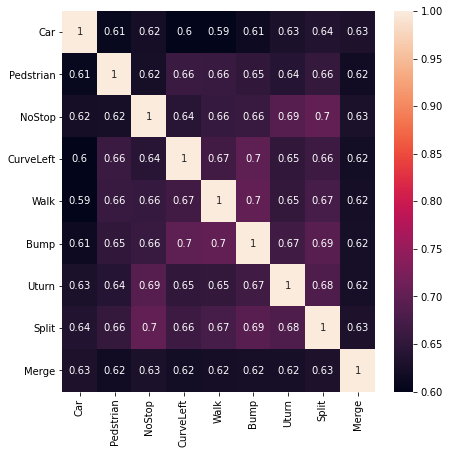

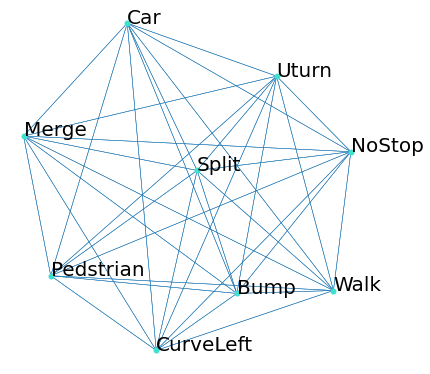

Size: 125 finished ----------------------------------------------------
--- 270.178653717041 seconds ---


In [17]:
print("Start Evaluating: ")
start_time = time.time()
for size in range(5, 130, 5):
    print(f"size is {size}")
    result_W = np.zeros((9,9))
    
    x_train_small, y_train_small = random_choise(x_train, y_train, M=size)
    CSG = []
    model, encoder = train_autoencoder(x_train_small, int(5000*50/(size*100)))
    for k in range(5):
        X_test, Y_test = random_choise(x_test, y_test)
        #print(np.sum(to_categorical(Y_test), axis=0))

        for i in range(5):
            X_tsne = t_sne(X_test, Y_test, encoder, fig=False)
            S = make_S(X_tsne, Y_test)
            W = w_ij(S)
            CSG.append(csg(W))
            result_W += W
    print("data size=", size, ": csg=",np.mean(CSG))

    # MDS
    if size == 125:
        result_W /= 25
        plt.figure(figsize=(7,7))
        sns.heatmap(result_W, annot=True, xticklabels=mds_label, yticklabels=mds_label, vmin=0.6, vmax=1)
        plt.show()

        MDS(result_W)
    print(f"Size: {size} finished ----------------------------------------------------")
end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))

Start Evaluating: 
size is 5
data size= 5 : csg= 4.646215984632725
Size: 5 finished ----------------------------------------------------
size is 10
data size= 10 : csg= 4.4946246978435695
Size: 10 finished ----------------------------------------------------
size is 15
data size= 15 : csg= 4.674086317249728
Size: 15 finished ----------------------------------------------------
size is 20
data size= 20 : csg= 4.721749039280713
Size: 20 finished ----------------------------------------------------
size is 25
data size= 25 : csg= 4.88229623334026
Size: 25 finished ----------------------------------------------------
size is 30
data size= 30 : csg= 4.805705447887782
Size: 30 finished ----------------------------------------------------
size is 35
data size= 35 : csg= 4.341300426493349
Size: 35 finished ----------------------------------------------------
size is 40
data size= 40 : csg= 4.779304938012744
Size: 40 finished ----------------------------------------------------
size is 45
data 

data size= 55 : csg= 4.6253960676488655
Size: 55 finished ----------------------------------------------------
size is 60
data size= 60 : csg= 4.43299115289828
Size: 60 finished ----------------------------------------------------
size is 65
data size= 65 : csg= 4.784670513244141
Size: 65 finished ----------------------------------------------------
size is 70
data size= 70 : csg= 4.084739467967275
Size: 70 finished ----------------------------------------------------
size is 75
data size= 75 : csg= 4.604195367497293
Size: 75 finished ----------------------------------------------------
size is 80
data size= 80 : csg= 4.782046309786329
Size: 80 finished ----------------------------------------------------
size is 85
data size= 85 : csg= 4.501245717353894
Size: 85 finished ----------------------------------------------------
size is 90
data size= 90 : csg= 4.187826968803273
Size: 90 finished ----------------------------------------------------
size is 95
data size= 95 : csg= 4.870761136

data size= 110 : csg= 4.594286810091037
Size: 110 finished ----------------------------------------------------
size is 115
data size= 115 : csg= 4.931349448557485
Size: 115 finished ----------------------------------------------------
size is 120
data size= 120 : csg= 4.502002799062228
Size: 120 finished ----------------------------------------------------
size is 125
data size= 125 : csg= 4.755818583488703


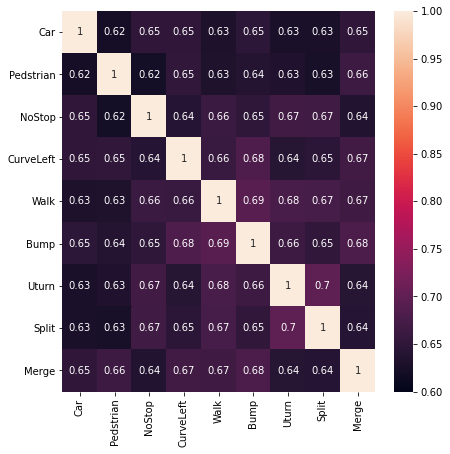

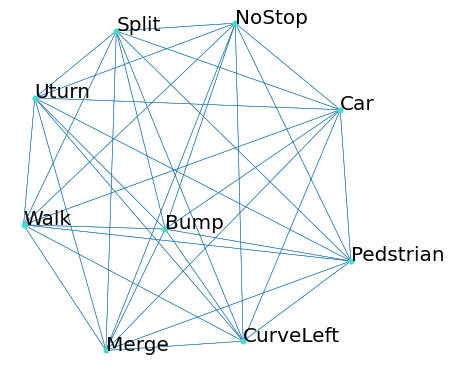

Size: 125 finished ----------------------------------------------------
--- 1049.7164952754974 seconds ---


In [17]:
print("Start Evaluating: ")
start_time = time.time()
for size in range(5, 130, 5):
    print(f"size is {size}")
    result_W = np.zeros((9,9))
    
    x_train_small, y_train_small = random_choise(x_train, y_train, M=size)
    CSG = []
    model, encoder = train_autoencoder(x_train_small, int(50000*50/(size*100)))
    for k in range(5):
        X_test, Y_test = random_choise(x_test, y_test)
        #print(np.sum(to_categorical(Y_test), axis=0))

        for i in range(5):
            X_tsne = t_sne(X_test, Y_test, encoder, fig=False)
            S = make_S(X_tsne, Y_test)
            W = w_ij(S)
            CSG.append(csg(W))
            result_W += W
    print("data size=", size, ": csg=",np.mean(CSG))

    # MDS
    if size == 125:
        result_W /= 25
        plt.figure(figsize=(7,7))
        sns.heatmap(result_W, annot=True, xticklabels=mds_label, yticklabels=mds_label, vmin=0.6, vmax=1)
        plt.show()

        MDS(result_W)
    print(f"Size: {size} finished ----------------------------------------------------")
end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))

In [1]:

%load_ext tensorboard


In [2]:
%tensorboard --logdir //home/admin1/Documents/EmanEhab/keras-yolo3-master/logs/000_logs_trainingfromscratch
